<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Deep Learning Para Aplicações de Inteligência Artificial com Python e C++</font>
## <font color='blue'>Projeto 2</font>
## <font color='blue'>Fine-Tuning de Um Modelo Transformer Para Classificação de Sentimento</font>

In [1]:
import sys
print(sys.executable)

/opt/homebrew/opt/python@3.12/bin/python3.12


In [2]:
!{sys.executable} -m pip install spacy


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [3]:
!{sys.executable} -m pip install transformers


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [4]:
!{sys.executable} -m pip install -q -U watermark


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [5]:
!{sys.executable} -m pip install -q -U nltk


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [6]:
!{sys.executable} -m pip install pandas


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [7]:
!{sys.executable} -m pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [8]:
!{sys.executable} -m pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [9]:
!{sys.executable} -m pip install keras_preprocessing


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [10]:
# Imports
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Recall, AUC
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
df_train = pd.read_csv("train_data.txt", header=None, delimiter=";").rename(columns={0: "text", 1: "label"})
print(f"Train data shape: {df_train.shape}")
df_train.head()

Train data shape: (16000, 2)


,text,label
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [12]:
df_train['label'].value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [13]:
df_test = pd.read_csv("test_data.txt", header=None, delimiter=";").rename(columns={0: "text", 1: "label"})
print(f"Test data shape: {df_test.shape}")
df_test.head()

Test data shape: (2000, 2)


,text,label
0,i feel like my only role now would be to tear ...,sadness
1,i feel just bcoz a fight we get mad to each ot...,anger
2,i feel like reds and purples are just so rich ...,joy
3,im not sure the feeling of loss will ever go a...,sadness
4,i feel like ive gotten to know many of you thr...,joy


In [14]:
df_train['label'].value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [15]:
!{sys.executable} -m spacy download en_core_web_md -q


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [16]:
project_nlp = spacy.load("en_core_web_md")

def text_process(text):
    # Removing stopwords, extracting the stem of a word, etc
    doc = project_nlp(text)
    
    # Lemmatization
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]
    
    return " ".join(tokens)

In [17]:
df_train["processed_text"] = df_train["text"].apply(text_process)
df_train.head()

,text,label,processed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [18]:
df_test["processed_text"] = df_test["text"].apply(text_process)
df_test.head()

,text,label,processed_text
0,i feel like my only role now would be to tear ...,sadness,feel like role tear sail pessimism discontent
1,i feel just bcoz a fight we get mad to each ot...,anger,feel bcoz fight mad n u wanna publicity n let ...
2,i feel like reds and purples are just so rich ...,joy,feel like red purple rich kind perfect
3,im not sure the feeling of loss will ever go a...,sadness,m sure feeling loss away dull sweet feeling no...
4,i feel like ive gotten to know many of you thr...,joy,feel like ve get know comment email m apprecia...


# 1st Approach: Using a Fully Connected Neural Network FCNN

In [19]:
# Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer
tdidf = TfidfVectorizer(max_df=0.95,
        min_df=2, 
        stop_words="english",
    )

# Applying the vetorizer
df_train_tfidf = tdidf.fit_transform(df_train["processed_text"])
# Every single transformation applied on the training data should be applied on the test data
df_test_tfidf = tdidf.transform(df_test["processed_text"])
# And, on new data, after the deploy

In [20]:
df_train_tfidf.shape

(16000, 5587)

In [22]:
type(df_train_tfidf)

scipy.sparse._csr.csr_matrix

In [21]:
# Converting the input data to array
X_train_array = df_train_tfidf.toarray()
X_test_array = df_test_tfidf.toarray()

In [26]:
# Converting the features to a numeric representation

# Creating the label encoder
label_encoder = LabelEncoder()

# Transforming the target feature 
y_train_le = label_encoder.fit_transform(df_train["label"])
y_test_le = label_encoder.transform(df_test["label"])

# Dealing with the class imbalance

class_weights = compute_class_weight("balanced", 
    classes=np.unique(y_train_le), 
    y=y_train_le,
)

In [27]:
type(class_weights)

numpy.ndarray

In [29]:
# Splitting the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    X_train_array,
    y_train_le,
    test_size=0.2,
    random_state=42,
    stratify=y_train_le,
)

In [30]:
# Converting the target features to categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test_le)
y_val_cat = to_categorical(y_val)

In [31]:
# Creating the model

# Starting the sequential model - a linear stack of layers
model_v1 = Sequential()

# Adding the first fully connected layer
model_v1.add(Dense(4096, 
    activation="selu", # Scaled Exponential Linear Unit
    kernel_initializer="lecun_normal",
    input_shape=(X_train_array.shape[1],),
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
    )
)

# Adding the second fully connected layer
model_v1.add(Dense(2048, 
    activation="selu",
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
    )
)

# Adding the third fully connected layer
model_v1.add(Dense(1024, 
    activation="selu",
    kernel_initializer="lecun_normal",
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
    )
)

# Adding the fourth fully connected layer
# With 64 neurons and a selu activation function
model_v1.add(Dense(64, activation="selu",))

# Adding the output layer
# Only 6 neurons, one for each class we have
model_v1.add(Dense(6, activation="softmax"))

In [32]:
# Compiling the model and Summary

# Setting specific weights to the bias vector from the output layer
model_v1.layers[-1].bias.assign(class_weights)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [35]:
# Compiling the model
# Using the Adam optimizer

model_v1.compile(
    optimizer="Adam",
    loss=tf.losses.categorical_crossentropy,
    metrics=["accuracy"],
)

In [36]:
model_v1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4096)           │    22,888,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,443,270 (127.58 MB)

 Trainable params: 33,443,270 (127.58 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Callbacks and early stopping

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

In [40]:
# Learning rate scheduler
lr_scheduler = LearningRateScheduler(step_decay)

# Early stopping
early_stopping = EarlyStopping(monitor="val_loss",
    restore_best_weights=True,
    patience=3,
)

In [41]:
# Training the model

# Hiperparameters

num_epochs = 20
batch_size = 256

In [42]:
%%time
history = model_v1.fit(
    x_train, 
    y_train_cat,
    validation_data=(x_val, y_val_cat),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[lr_scheduler, early_stopping],
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 461ms/step - accuracy: 0.5202 - loss: 36.2729 - val_accuracy: 0.7944 - val_loss: 1.9002 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 431ms/step - accuracy: 0.8369 - loss: 1.4792 - val_accuracy: 0.8091 - val_loss: 1.3657 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 486ms/step - accuracy: 0.8724 - loss: 1.1016 - val_accuracy: 0.8300 - val_loss: 1.1505 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 464ms/step - accuracy: 0.9041 - loss: 0.9399 - val_accuracy: 0.8241 - val_loss: 1.1905 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 473ms/step - accuracy: 0.9178 - loss: 0.8912 - val_accuracy: 0.8366 - val_loss: 1.0904 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 483ms/step - accuracy: 0.9326 - loss: 0.8202 - val_accuracy: 0.8194 - val_loss: 1.2187 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9300 - loss: 0.90

In [43]:
# Rating the model after training

loss, val_loss = history.history["loss"], history.history["val_loss"]

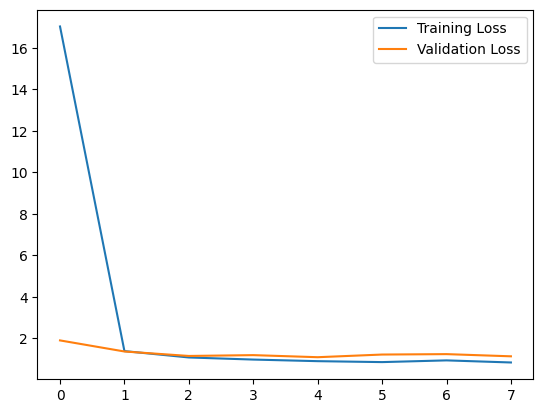

In [44]:
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.show()

In [45]:
# Using test data
test_v1 = model_v1.predict(X_test_array)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [46]:
# Extracting the predicted labels
y_pred_v1 = np.argmax(test_v1, axis=1)

In [47]:
print(classification_report(y_test_le, y_pred_v1))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       275
           1       0.81      0.81      0.81       224
           2       0.87      0.89      0.88       695
           3       0.74      0.60      0.66       159
           4       0.89      0.88      0.89       581
           5       0.68      0.67      0.67        66

    accuracy                           0.84      2000
   macro avg       0.80      0.78      0.79      2000
weighted avg       0.84      0.84      0.84      2000



In [48]:
print(confusion_matrix(y_test_le, y_pred_v1))

[[235   9  10   1  19   1]
 [ 15 182   4   0  10  13]
 [ 15   5 617  30  23   5]
 [  8   4  42  95   9   1]
 [ 23  15  27   2 513   1]
 [  3  10   8   0   1  44]]


In [49]:
print(accuracy_score(y_test_le, y_pred_v1))

0.843


In [50]:
# Saving the model
model_v1.save("model_v1_dsa.keras")

In [51]:
# Version 1 Deployment

loaded_model = load_model("model_v1_dsa.keras")

In [52]:
# Trying with a new data - sentiment: Fear

phrase = "I'm afraid of the dark"

df_new = pd.DataFrame({"text": [phrase]})
df_new["processed_text"] = df_new["text"].apply(text_process)

In [53]:
df_new

,text,processed_text
0,I'm afraid of the dark,afraid dark


In [54]:
# Applying the TF-IDF vectorizer
df_new_tfidf = tdidf.transform(df_new["processed_text"])

# Transforming the new data to an array
X_new_array = df_new_tfidf.toarray()

# Predicting the new data
new_pred = loaded_model.predict(X_new_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [56]:
class_high_prob = np.argmax(new_pred, axis=1)

class_name = label_encoder.inverse_transform(class_high_prob)
class_name

array(['fear'], dtype=object)